# Acquire

- https://www.latimes.com/california/story/2020-03-16/los-angeles-parking-ticket-street-sweeping-coronavirus-covid19
- https://www.latimes.com/california/story/2020-10-15/street-sweeping-parking-enforcement-resumes-today
- https://abc7.com/society/las-resumed-parking-enforcement-prompts-outcry/7079278/

- https://www.theeastsiderla.com/site/about_the_eastsider/
- https://xtown.la/2020/10/15/parking-ticket-los-angeles/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import spacy
import nltk
import re

from wordcloud import WordCloud
from spacy.lang.en.stop_words import STOP_WORDS

from pdfminer.high_level import extract_text
from transformers import pipeline

In [2]:
# Create an empty dictionary to scrape text from all the pdfs
# stored in the city-documents folder.
documents = []

for root, dirs, files in os.walk("city-documents/"):
    for file in files:
        # If the ends with .pdf, display the path
        if file.endswith(".pdf"):
            print(os.path.join(root, file))
            # Add the filename and relative path as a dictionary to documents
            documents.append({'pdf_name': file,
                              'path': os.path.join(root, file)})

city-documents/public-comments/public-comments-parking-enforcement.pdf
city-documents/LADOT-press-releases/enforcement.pdf
city-documents/LADOT-press-releases/citation-pay-program.pdf
city-documents/city-council-documents/LADOT-transition-plan.pdf
city-documents/city-council-documents/public-outreach-period.pdf
city-documents/city-council-documents/relief-report-motion.pdf
city-documents/city-council-documents/relief-program-report-121720.pdf


In [3]:
# Load in the text from a pdf using pdfminer
extract_text('city-documents/city-council-documents/LADOT-transition-plan.pdf')[:500]

'CITY OF LOS ANGELES\nINTER-DEPARTMENTAL MEMORANDUM\n\nDate:\n\nSeptember 17, 2020\n\nTo:\n\nHonorable City Council\nc/o City Clerk, Room 395, City Hall\nAttention: Honorable Mike Bonin, Chair, Transportation Committee\n\nFrom:\n\nSeleta J. Reynolds, General Manager ^ \nDepartment of Transportation\n\nSubject:\n\nTRANSITION PLAN TO RESUME PARKING ENFORCEMENT FOR PREVIOUSLY SUSPENDED \n\nPARKING INFRACTIONS AND PROPOSED ECONOMIC RELIEF MEASURES FOR PARKING \n\nFINES\n\nSUMMARY\n\nThe Los Angeles Department of Transportation '

In [4]:
# Convert the list of dictionaries into a dataframe
pdfs = pd.DataFrame(documents)
pdfs

,pdf_name,path
0,public-comments-parking-enforcement.pdf,city-documents/public-comments/public-comments...
1,enforcement.pdf,city-documents/LADOT-press-releases/enforcemen...
2,citation-pay-program.pdf,city-documents/LADOT-press-releases/citation-p...
3,LADOT-transition-plan.pdf,city-documents/city-council-documents/LADOT-tr...
4,public-outreach-period.pdf,city-documents/city-council-documents/public-o...
5,relief-report-motion.pdf,city-documents/city-council-documents/relief-r...
6,relief-program-report-121720.pdf,city-documents/city-council-documents/relief-p...


In [5]:
# Create an empty list to store text extracted from each pdf.
text = []

# Scrape the text from each pdf and store the result in text
for index, file in pdfs.iterrows():
    text.append(extract_text(file['path']))

In [6]:
# Display the number of documents stored in the variable `text`.
len(text)

7

# Prepare

In [7]:
# Display the first 20 characters of each docuemnt in the variable `text`.
for i in range(0, len(text)):
    print(f"\nDOCUMENT #{i+1}")
    print("-----------------")
    print(text[i][:30].strip())
    


DOCUMENT #1
-----------------
Communication from Public

DOCUMENT #2
-----------------
FOR IMMEDIATE RELEAS

DOCUMENT #3
-----------------
FOR IMMEDIATE RELEAS

DOCUMENT #4
-----------------
CITY OF LOS ANGELES
INTER-DEPA

DOCUMENT #5
-----------------
MOTION

3 0 A

I MOVE that the

DOCUMENT #6
-----------------
TRANSPORTATION

MOTION

On Oct

DOCUMENT #7
-----------------
File No. 20-1365

TRANSPORTATI


In [8]:
# text[4] contains the pdf named 'city-documents/public-comments/public-comments-parking-enforcement.pdf'
# It is a collection of citizens comments on parking reinforcement during town hall meetings.
public_comments = text[0].replace("\xa0", ' ').lower()
public_comments = public_comments.replace('no: comments for public posting:',  '')
public_comments = public_comments.replace('communication from public',  '')
public_comments = ' '.join(public_comments.split())

In [9]:
# Display the first 200 characters to ensure excess spaces and conversion residue is removed from the string.
public_comments[:200]

"name: date submitted: council file no: comments for public posting: my comments are in reference to item #3 of today's armen makasjian 08/17/2020 01:30 pm 20-0147-s7 transportation committee meeting. "

# Exploratory Data Analysis

In [10]:
# Instantiate a model to analyze the public comments and determine sentiment.
classifier = pipeline('sentiment-analysis')

# Create an nlp object and pass the public comments into the object to create a spaCy doc object.
nlp = spacy.load('en_core_web_lg')
doc = nlp(public_comments)

# Create a list non-stop words.
# Use spaCy's built-in tokenizer, is_stop, and is_punct attribute to remove all stopwords from the doc object.
filtered_words = [token.text for token in doc if not token.is_stop and not token.is_punct]

## Sentiment-Analysis on a Sentence Level

In [11]:
# Create a dataframe to store the sentiment of each sentence from the public comment
# documents provided by the City Clerk's Office.
df_sentence_sentiment = pd.DataFrame()

for sentence in doc.sents:
    # For each sentence analyze the sentiment
    sentence = str(sentence.as_doc())
    
    if ('sweep' in sentence) or ('parking enforcement' in sentence):
        # Store the sentiment data dict to a variable
        sentiment_data = classifier(sentence)
        
        # Extract the Store sentiment score of the sentence as a variable.
        sentiment_score = sentiment_data[0]['score']

        # Extract the sentiment and score from the dict
        sentiment = sentiment_data[0]['label']
        
        # Append the word, sentiment label, and sentiment score as a row in a dataframe
        df_sentence_sentiment = df_sentence_sentiment.append([{'sentence': sentence,
                                                               'sentiment': sentiment,
                                                               'score': sentiment_score}])

df_sentence_sentiment.reset_index(drop=True, inplace=True)

In [12]:
df_sentence_sentiment

,sentence,sentiment,score
0,it is important that street sweeping continue ...,POSITIVE,0.999168
1,it is important that the city continue street ...,POSITIVE,0.995944
2,please reconsider the motion to continue stree...,NEGATIVE,0.965585
3,p. 09/28/2020 09:01 pm 20-0147-s7 name: date s...,POSITIVE,0.966261
4,prior to the suspension of parking enforcement...,POSITIVE,0.999528
5,name: date submitted: council file no: comment...,NEGATIVE,0.993569
6,jazmine johnson 09/30/2020 10:40 am 20-0147-s7...,NEGATIVE,0.990011
7,"moreover, unhoused folks, who are already some...",NEGATIVE,0.999020
8,"for example, maybe the city can reduce costs b...",NEGATIVE,0.998507
9,why resume parking enforcement now?,NEGATIVE,0.999232


In [13]:
df_sentence_sentiment.sentiment.value_counts(normalize=True)

NEGATIVE    0.538462
POSITIVE    0.461538
Name: sentiment, dtype: float64

In [14]:
for i in df_sentence_sentiment.sentence:
    print(i.capitalize(), end='\n\n')

It is important that street sweeping continue through neighborhoods. 

It is important that the city continue street sweeping to prevent blight and unsanitary conditions. 

Please reconsider the motion to continue street sweeping. 

P. 09/28/2020 09:01 pm 20-0147-s7 name: date submitted: council file no: comments for public posting: my name is name is scott and i live in el sereno and i want to encourage the council to direct the los angeles department of transportation (ladot) to resume parking enforcement for previously suspended parking infractions and proposed economic relief measures for parking fines as recommended by the transportation commission. 

Prior to the suspension of parking enforcement, ladot did a wonderful job of enforcing parking and removing abandoned vehicles. 

Name: date submitted: council file no: comments for public posting: i strongly oppose the transportation committee’s jeanne 09/30/2020 09:27 am 20-0147-s7 recommendation to resume parking enforcement, incl

## Sentiment-Analysis on a Word Level

In [15]:
# Create a dataframe to store the sentiment of each WORD from the public comment
# documents provided by the City Clerk's Office.
df_word_sentiment = pd.DataFrame()

for word in filtered_words:
    # For each filtered token, analyze the sentiment
    if word.isalpha():
        sentiment_data = classifier(word)[0]

        # Extract the sentiment and score from the dict
        sentiment = sentiment_data['label']
        score = sentiment_data['score']
        
        # Store the sentiment score of the sentence to a variable.
        sentiment_score = sentiment_data['score']
    
        if sentiment_score >= .95:

        # Append the word, sentiment, and score as a row in a dataframe
            df_word_sentiment = df_word_sentiment.append([{'word': word.lower(),
                                                           'sentiment': sentiment,
                                                           'score': score}])
df_word_sentiment.reset_index(drop=True, inplace=True)

In [16]:
df_word_sentiment.head()

,word,sentiment,score
0,date,POSITIVE,0.998968
1,submitted,POSITIVE,0.994183
2,council,POSITIVE,0.990301
3,comments,POSITIVE,0.989478
4,public,POSITIVE,0.998105


In [17]:
df_word_sentiment.sentiment.value_counts(normalize=True)

POSITIVE    0.796407
NEGATIVE    0.203593
Name: sentiment, dtype: float64

In [18]:
df_word_sentiment.groupby(by=['sentiment', 'word']).agg('count').sort_values('score', ascending=False).head()

score
sentiment word              
POSITIVE  parking         29
          city            21
          people          20
          enforcement     17
          council         15

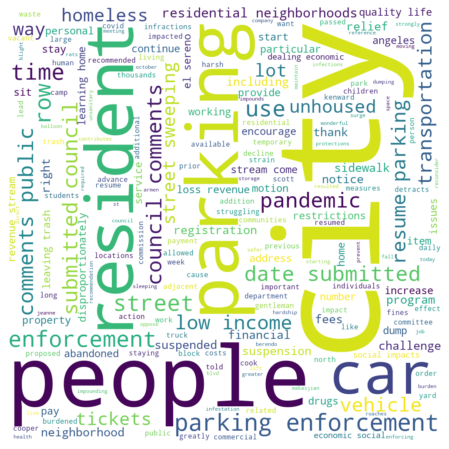

In [19]:
sentence = ' '.join(df_word_sentiment.word)

plt.figure(figsize=(8, 8))

img = WordCloud(background_color='white',
                stopwords=STOP_WORDS,
                width=1000,
                height=1000
               ).generate(sentence)

plt.imshow(img, interpolation="bilinear")

plt.axis('off');